In [25]:
import pandas as pd
filename = '../average_distances.csv'

df = pd.read_csv(filename)

dict_summary = {
    'model': [],
    'average_intra_group_distance': [],
    'average_inter_group_distance': []
}

models = df['model_name'].unique()
for model in models:
    df_model = df[df['model_name'] == model]
    average_intra_group_distance = df_model['group_distance'].mean()
    average_inter_group_distance = df_model['total_distance'].mean()

    dict_summary['model'].append(model)
    dict_summary['average_intra_group_distance'].append(average_intra_group_distance)
    dict_summary['average_inter_group_distance'].append(average_inter_group_distance)

summary_df = pd.DataFrame(dict_summary)


print(summary_df.to_markdown())
print()

|    | model                                |   average_intra_group_distance |   average_inter_group_distance |
|---:|:-------------------------------------|-------------------------------:|-------------------------------:|
|  0 | ./TripletLoss/models/sbert_model_10  |                       0.175637 |                       0.317729 |
|  1 | ./TripletLoss/models/sbert_model_20  |                       0.226314 |                       0.506436 |
|  2 | ./TripletLoss/models/sbert_model_30  |                       0.233547 |                       0.58757  |
|  3 | ./TripletLoss/models/sbert_model_40  |                       0.24496  |                       0.656147 |
|  4 | ./TripletLoss/models/sbert_model_50  |                       0.249623 |                       0.695558 |
|  5 | ./TripletLoss/models/sbert_model_60  |                       0.260074 |                       0.728958 |
|  6 | ./TripletLoss/models/sbert_model_70  |                       0.272453 |                       0.7

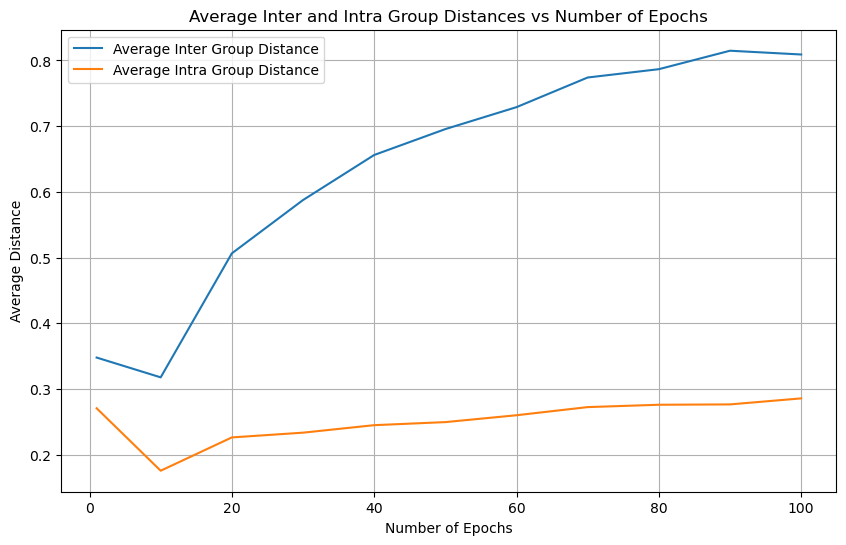

In [26]:
num_epochs = []
average_inter_group_distances = []
average_intra_group_distances = []
for model in models:
    model_df = summary_df[summary_df['model'] == model]
    num_epochs.append(int(model.split('_')[-1]))
    average_inter_group_distances.append(model_df['average_inter_group_distance'].item())
    average_intra_group_distances.append(model_df['average_intra_group_distance'].item())

import numpy as np
import matplotlib.pyplot as plt

#sort the values of x before line plot
sort_axis = np.argsort(num_epochs)
num_epochs = np.array(num_epochs)[sort_axis]
average_inter_group_distances = np.array(average_inter_group_distances)[sort_axis]
average_intra_group_distances = np.array(average_intra_group_distances)[sort_axis]

# plot the average inter and intera group distance vs number of epochs with title and labels for x and y axis and legend
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(num_epochs, average_inter_group_distances, label='Average Inter Group Distance')
ax.plot(num_epochs, average_intra_group_distances, label='Average Intra Group Distance')
ax.set_title('Average Inter and Intra Group Distances vs Number of Epochs')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Average Distance')
ax.grid()
ax.legend()
plt.savefig('../figs/average_inter_and_intra_group_distances_vs_number_of_epochs.png')
plt.show()




In [19]:
import matplotlib.pyplot as plt
import numpy as np

# df.columns
# Index(['group_id', 'group_distance', 'total_distance', 'model_name'], dtype='object')

#grouped bar chart for group distance of models with specific number of epochs
# the x locations for the groups
def plot_bar_compare(df, target_epochs, model_base='./TripletLoss/models/sbert_model', score='group_distance', save_name=None, show=True):

    model_name_1 = f'{model_base}_{target_epochs[0]}'
    model_name_2 = f'{model_base}_{target_epochs[1]}'
    df1 = df[df['model_name'] == model_name_1]
    df2 = df[df['model_name'] == model_name_2]

    ind = np.arange(len(df1['group_id']))
    width = 0.35

    plt.figure(figsize=(10, 5))

    plt.bar(ind, df1[score], width, label=f'Epoch: {target_epochs[0]}')
    plt.bar(ind + width, df2[score], width, label=f'Epoch: {target_epochs[1]}')

    plt.ylabel('Average distance')
    plt.title('Average distance within groups')

    plt.legend(loc='best')

    plt.xticks(ind + width / 2, df1['group_id'])
    if save_name:
        plt.savefig(f'../figs/{save_name}.png')
    if show:
        plt.show()


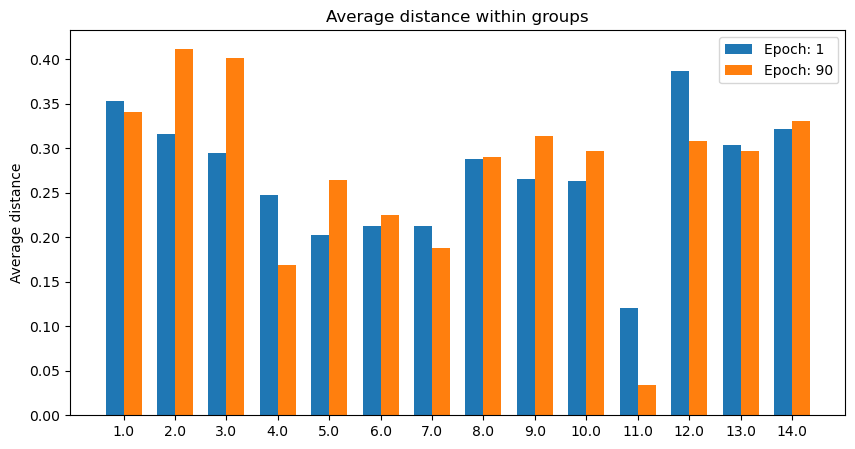

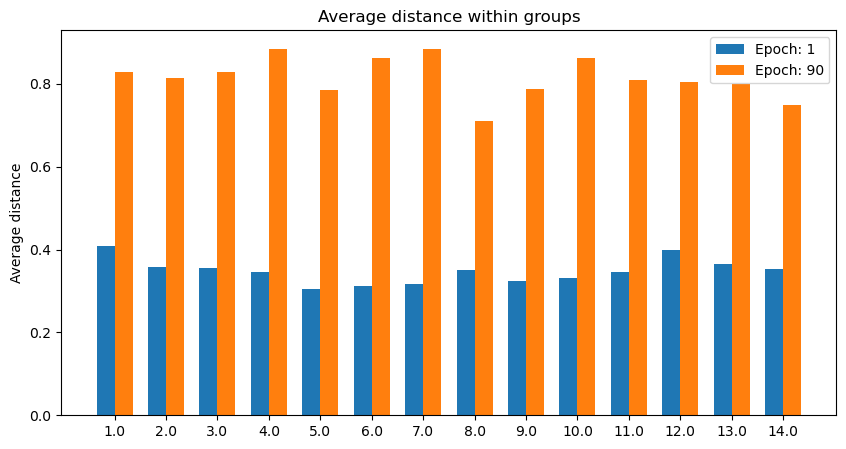

In [20]:
socres= ['group_distance', 'total_distance']
target_epochs = [1, 90]
for score in socres:
    save_name = f'group_distance_{score}'
    plot_bar_compare(df, target_epochs, save_name=save_name, score=score, show=False)
